In [2]:
import torch
from torch.autograd import Function
import torch.optim as optim
import torch.nn as nn

In [3]:
from qiskit import execute
from qiskit.circuit import Parameter,ControlledGate
from qiskit import Aer
import qiskit
import numpy as np

In [4]:
from tqdm import tqdm

In [5]:
from matplotlib import pyplot as plt
%matplotlib inline

In [6]:
np.random.seed = 42

NUM_QUBITS = 3
NUM_SHOTS = 3000
SHIFT = np.pi/4
LEARNING_RATE = 0.01
MOMENTUM = 0.5

SIMULATOR = Aer.get_backend('qasm_simulator')

In [7]:
import itertools
def create_QC_OUTPUTS():
    measurements = list(itertools.product([0, 1], repeat=NUM_QUBITS))
    return [''.join([str(bit) for bit in measurement]) for measurement in measurements]

QC_OUTPUTS = create_QC_OUTPUTS()
print(QC_OUTPUTS)

['000', '001', '010', '011', '100', '101', '110', '111']


In [8]:
class QiskitCircuit():
    
    def __init__(self, n_qubits, backend, shots):
        # --- Circuit definition ---
        self.circuit = qiskit.QuantumCircuit(n_qubits)
        self.n_qubits = n_qubits
        self.thetas ={k : Parameter('Theta'+str(k))for k in range(self.n_qubits)}
        
        all_qubits = [i for i in range(n_qubits)]
        self.circuit.h(all_qubits)
        self.circuit.barrier()
        for k in range(n_qubits):
            self.circuit.ry(self.thetas[k], k)

        self.circuit.measure_all()
        # ---------------------------
        
        self.backend = backend
        self.shots = shots
        
    def N_qubit_expectation_Z(self,counts, shots, nr_qubits):
        expects = np.zeros(len(QC_OUTPUTS))
        for k in range(len(QC_OUTPUTS)):
            key = QC_OUTPUTS[k]
            perc = counts.get(key, 0) /shots
            expects[k] = perc
        return expects
    
    def run(self, i):
        params = i
        backend = Aer.get_backend('qasm_simulator')
    
        bound_circuit = self.circuit.bind_parameters({self.thetas[k] : params[k].item() for k in range(NUM_QUBITS)}) 
        job_sim = execute(bound_circuit, self.backend, shots=self.shots)
        
        result_sim = job_sim.result()
        counts = result_sim.get_counts()
        return self.N_qubit_expectation_Z(counts,self.shots,NUM_QUBITS)

Expected value for rotation [pi/4]: [0.00233333 0.02066667 0.01466667 0.10433333 0.016      0.106
 0.10066667 0.63533333]


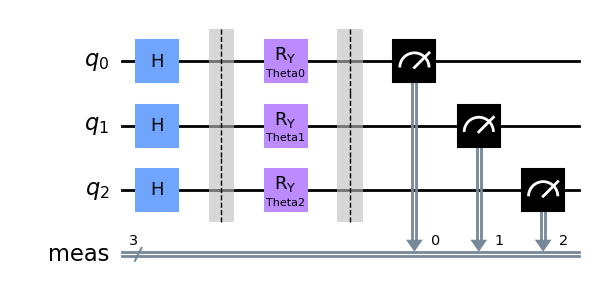

In [9]:
circuit = QiskitCircuit(NUM_QUBITS, SIMULATOR, NUM_SHOTS)
print('Expected value for rotation [pi/4]: {}'.format(circuit.run(torch.Tensor([np.pi/4]*NUM_QUBITS))))
circuit.circuit.draw(output='mpl')

In [10]:
class TorchCircuit(Function):    

    @staticmethod
    def forward(ctx, i):
        if not hasattr(ctx, 'QiskitCirc'):
            ctx.QiskitCirc = QiskitCircuit(NUM_QUBITS, SIMULATOR, shots=NUM_SHOTS)
            
        exp_value = ctx.QiskitCirc.run(i)
        
        result = torch.tensor([exp_value])
        
        
        ctx.save_for_backward(result, i)
        
        return result
    
    @staticmethod
    def backward(ctx, grad_output):
        
        forward_tensor, i = ctx.saved_tensors
        input_numbers = i
        gradients = torch.Tensor()
        
        for k in range(NUM_QUBITS):
            shift_right = input_numbers.detach().clone()
            shift_right[k] = shift_right[k] + SHIFT
            shift_left = input_numbers.detach().clone()
            shift_left[k] = shift_left[k] - SHIFT
            
            
            expectation_right = ctx.QiskitCirc.run(shift_right)
            expectation_left  = ctx.QiskitCirc.run(shift_left)
            
            gradient = torch.tensor([expectation_right]) - torch.tensor([expectation_left])
            gradients = torch.cat((gradients, gradient.float()))
            
        result = torch.Tensor(gradients)

        return (result.float() * grad_output.float()).T

In [11]:
x = torch.tensor([np.pi/4]*NUM_QUBITS, requires_grad=True)

qc = TorchCircuit.apply
y1 = qc(x)
print('y1 after quantum layer: {}'.format(y1))
y1 = nn.Linear(2**NUM_QUBITS,1)(y1.float())
y1.backward()
print('x.grad = {}'.format(x.grad))

y1 after quantum layer: tensor([[0.0040, 0.0167, 0.0153, 0.1067, 0.0167, 0.1123, 0.1060, 0.6223]],
       dtype=torch.float64, grad_fn=<TorchCircuitBackward>)
x.grad = tensor([-0.1150,  0.1329,  0.0255])


/tmp/ipykernel_23431/1768170039.py:10: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /opt/conda/conda-bld/pytorch_1682343964576/work/torch/csrc/utils/tensor_new.cpp:245.)
  result = torch.tensor([exp_value])


### MNIST in pytorch

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [14]:
import numpy as np
import torchvision
from torchvision import datasets, transforms

n_samples = 150

X_train = datasets.MNIST(root='./data', train=True, download=True,
                         transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_train.targets == 0)[0][:n_samples], 
                np.where(X_train.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_train.targets == 7)[0][:n_samples])

X_train.data = X_train.data[idx]
X_train.targets = X_train.targets[idx]


train_loader = torch.utils.data.DataLoader(X_train, batch_size=1, shuffle=True, pin_memory=True)

**Testing Data**

In [15]:
n_samples = 150

X_test = datasets.MNIST(root='./data', train=False, download=True,
                        transform=transforms.Compose([transforms.ToTensor()]))

idx = np.append(np.where(X_test.targets == 0)[0][:n_samples], 
                np.where(X_test.targets == 1)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 2)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 3)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 4)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 5)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 6)[0][:n_samples])
idx = np.append(idx, 
                np.where(X_test.targets == 7)[0][:n_samples])

X_test.data = X_test.data[idx]
X_test.targets = X_test.targets[idx]

test_loader = torch.utils.data.DataLoader(X_test, batch_size=1, shuffle=True)

In [16]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, NUM_QUBITS)
        self.qc = TorchCircuit.apply
        self.qcsim = nn.Linear(NUM_QUBITS, 1)
        self.fc3 = nn.Linear(1, 4)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        x = np.pi*torch.tanh(x)
        
    
        if MODE == 'QC': 
            x = qc(x[0]) # QUANTUM LAYER
        
        else:
            x = self.qcsim(x)

        x = torch.sigmoid(x)
        x = torch.cat((x, 1-x), -1)
        return x
    
    
    def predict(self, x):
        pred = self.forward(x)
        ans = torch.argmax(pred[0]).item()
        return torch.tensor(ans)
    
network = Net()
optimizer = optim.Adam(network.parameters(), lr=0.001)

In [17]:
total_params = sum(p.numel() for p in network.parameters() if p.requires_grad)
print("Number of trainable parameters:", total_params)

Number of trainable parameters: 21495


In [18]:
epochs = 10
loss_list = []
val_loss_list = []
loss_func = nn.CrossEntropyLoss()
best = 0

for epoch in range(epochs):
    network.train()
    
    total_loss = []
    for batch_idx, (data, target) in enumerate(tqdm(train_loader)):
#         print(batch_idx)
        optimizer.zero_grad()        
        # Forward pas
        output = network(data)
        # Calculating loss
        loss = loss_func(output, target)
        # Backward pass
        loss.backward()
        # Optimize the weights
        optimizer.step()
        
        total_loss.append(loss.item())
        
    loss_list.append(sum(total_loss)/len(total_loss))
    print('Training [{:.0f}%]\tLoss: {:.4f}'.format(
        100. * (epoch + 1) / epochs, loss_list[-1]))
    
    network.eval()
    
    accuracy = 0
    number = 0
    
    with torch.no_grad():
        total_val_loss = []
        for batch_idx, (data, target) in enumerate(test_loader):
            number +=1
            output = network(data)
            
            # Calculating loss
            loss = loss_func(output, target)
            
            output = network.predict(data).item()
            
            total_val_loss.append(loss.item())
        
            accuracy += (output == target[0].item())*1
            
        accuracy = 100*accuracy/number
        
        if accuracy > best:
            best = accuracy
            torch.save(network.state_dict(), 'mnist 0-7 3qubits.pth')
            
        val_loss_list.append(sum(total_val_loss)/len(total_val_loss))
        print("Val loss: {} and accuracy = {}%".format(val_loss_list[-1],accuracy))

100%|███████████████████████████████████████| 1200/1200 [01:30<00:00, 13.19it/s]


Training [10%]	Loss: 2.7045
Val loss: 2.646001460130724 and accuracy = 67.91666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:29<00:00, 13.46it/s]


Training [20%]	Loss: 2.6570
Val loss: 2.620872984691504 and accuracy = 83.08333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:28<00:00, 13.62it/s]


Training [30%]	Loss: 2.6416
Val loss: 2.607980522632993 and accuracy = 87.08333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:27<00:00, 13.64it/s]


Training [40%]	Loss: 2.6314
Val loss: 2.592991413497092 and accuracy = 90.25%


100%|███████████████████████████████████████| 1200/1200 [01:28<00:00, 13.62it/s]


Training [50%]	Loss: 2.6273
Val loss: 2.597343894425468 and accuracy = 89.08333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:27<00:00, 13.64it/s]


Training [60%]	Loss: 2.6209
Val loss: 2.5872351089014507 and accuracy = 92.83333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:28<00:00, 13.63it/s]


Training [70%]	Loss: 2.6211
Val loss: 2.5908299722748738 and accuracy = 92.25%


100%|███████████████████████████████████████| 1200/1200 [01:27<00:00, 13.65it/s]


Training [80%]	Loss: 2.6159
Val loss: 2.5843972190285367 and accuracy = 93.58333333333333%


100%|███████████████████████████████████████| 1200/1200 [01:27<00:00, 13.64it/s]


Training [90%]	Loss: 2.6142
Val loss: 2.5874006953704 and accuracy = 92.66666666666667%


100%|███████████████████████████████████████| 1200/1200 [01:28<00:00, 13.62it/s]


Training [100%]	Loss: 2.6113
Val loss: 2.5871942202650633 and accuracy = 93.75%


In [19]:
print('Best accuracy = {}'.format(best))

Best accuracy = 93.75


/tmp/ipykernel_23431/3416949679.py:4: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-darkgrid')


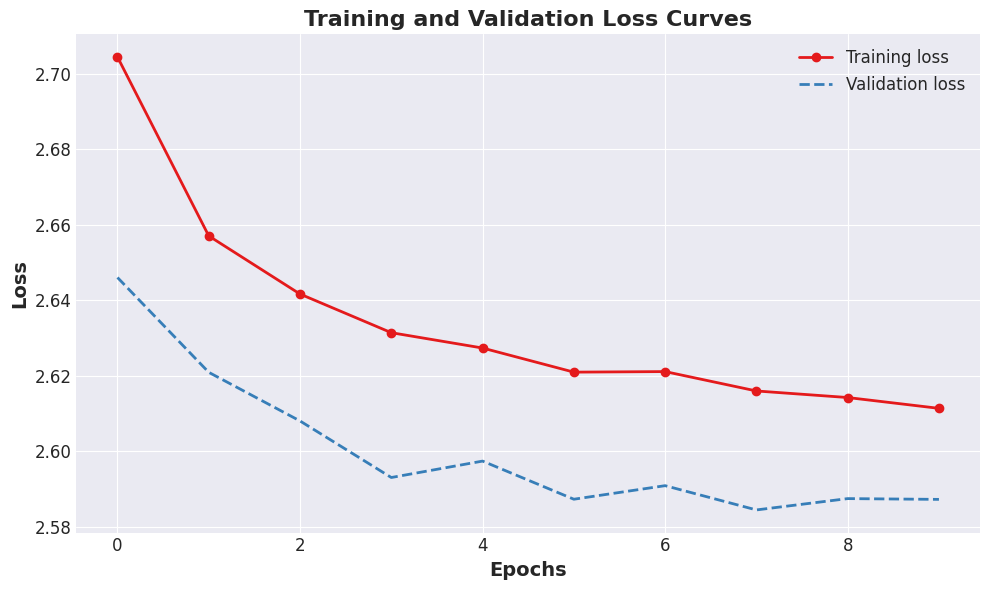

In [22]:
import matplotlib.pyplot as plt

# Use a professional style
plt.style.use('seaborn-darkgrid')

# Create a color palette
color_palette = plt.get_cmap('Set1')

# Set up the figure and axes
fig, ax = plt.subplots(figsize=(10, 6))

# Plotting both the curves simultaneously with enhanced aesthetics
ax.plot(loss_list, color=color_palette(0), marker='o', linestyle='-', linewidth=2, label='Training loss')
ax.plot(val_loss_list, color=color_palette(1), marker='', linestyle='--', linewidth=2, label='Validation loss')

# Naming the x-axis, y-axis and the whole graph with enhanced font properties
ax.set_xlabel("Epochs", fontsize=14, fontweight='bold')
ax.set_ylabel("Loss", fontsize=14, fontweight='bold')
ax.set_title("Training and Validation Loss Curves", fontsize=16, fontweight='bold')

# Displaying the legend with larger font size
ax.legend(fontsize=12)

# Enhance tick visibility and size
ax.tick_params(axis='both', which='major', labelsize=12)

# Adjust the plot for better layout
plt.tight_layout()

# Saving the graph in high quality
plt.savefig("mnist 0-7 3qubits loss curve.png", dpi=300)

# Displaying the graph
plt.show()
